# Square Gradient Theory for Mixtures

Square Gradient Theory allows studying the interfacial behavior of fluid. SGT proposes that the Helmholtz free energy density at the interface can be described by the sum of a homogeneous and a gradient contribution, in which the density profiles between the bulk phases are mean to minimize the energy of the system. This results in the following Euler-Lagrange system: 

$$ \sum_j c_{ij} \frac{d^2 \rho_j}{dz^2} = \mu_i - \mu_i^0 \qquad i = 1,...,c$$ 
$$ \rho(z \rightarrow -\infty) = \rho^\alpha \qquad \rho(z \rightarrow \infty) = \rho^\beta $$

Here, $z$ represents the interfacial position,  $\mu$, the chemical potential and $\rho$ the density vector. The superscript 0 refers to the bulk phase value and $\alpha$, $\beta$ to the bulk phases index. Finally, $c_{ij}$, represents the cross-influence parameter between molecule $i$ and $j$ and, in general, is computed as the geometric mean of the pure fluid's influence parameter and a correction factor:

$$ c_{ij} = (1 - \beta_{ij}) \sqrt{c_{ii} c_{jj}} $$

The solution procedure of the SGT strongly depends on whether the influence parameter matrix is singular or not. If all $\beta_{ij} = 0$, the matrix is singular and the differential equation reduces to the following algebraic system of equations.

$$ \sqrt{c_{rr}} \left[ \mu_i - \mu_i^0 \right] = \sqrt{c_{ii}} \left[ \mu_r - \mu_r^0 \right] \qquad  i = 1,...,c, i \neq r $$

Here $r$ refers to the reference component index.

Once the density profiles are solved the interfacial tension can be computed as:

$$ \sigma =  \int_{-\infty}^{\infty} \sum_i \sum_j c_{ij} \frac{d\rho_i}{dz} \frac{d\rho_j}{dz} dz $$

This notebook has the purpose of showing examples of computing interfacial tension of mixtures and $\beta_{ij} = 0$.

First, it's needed to import the necessary modules

In [1]:
import numpy as np
from SGTPy import component, mixture, saftvrmie
from SGTPy.equilibrium import bubblePy
from SGTPy.sgt import sgt_mix_beta0
import matplotlib.pyplot as plt

Then a mixture and the EoS are created.

In [2]:
water = component('water', ms = 1.7311, sigma = 2.4539 , eps = 110.85,
                    lambda_r = 8.308, lambda_a = 6.,  eAB = 1991.07, rcAB = 0.5624,
                    rdAB = 0.4, sites = [0,2,2], cii = 1.5371939421515455e-20)

ethanol = component('ethanol2C', ms = 1.7728, sigma = 3.5592 , eps = 224.50,
                    lambda_r = 11.319, lambda_a = 6., eAB = 3018.05, rcAB = 0.3547,
                    rdAB = 0.4, sites = [1,0,1], cii= 5.3141080872882285e-20)

mix = mixture(ethanol, water)
# or
mix = ethanol + water

kij, lij = np.array([-0.0069751 , -0.01521566])
Kij = np.array([[0, kij], [kij, 0]])
Lij = np.array([[0., lij], [lij, 0]])
# setting interactions corrections
mix.kij_saft(Kij)
mix.lij_saft(Lij)
# creating eos model
eos = saftvrmie(mix)

With the ``eos`` object the equilibrium point is computed with the ``bubblePy`` function.  For this example, the bubble point of a mixture of x1 = 0.2 at 298.15K is computed.

In [3]:
T = 298.15 # K
# liquid composition
x = np.array([0.2, 0.8])
# initial guesses
P0 = 1e4 # Pa
y0 = np.array([0.8, 0.2])
sol = bubblePy(y0, P0, x, T, eos, full_output=True)
y, P = sol.Y, sol.P
vl, vv = sol.v1, sol.v2

#computing the density vector
rhol = x/vl
rhov = y/vv

If the ```full_output``` is set to false, the densities vector of the phases can be computed as follows:

In [4]:
rhol = eos.density(x, T, P, 'L') * x
rhov = eos.density(y, T, P, 'V') * y

With the computed equilibrium values (rhov, rhol, T, P) SGT can be used to study the interfacial behavior of the mixture. 

To solve the density profiles there are two available method:
- ``reference``: used the reference component method. The parameter ``s`` sets the index for the reference component.
- ``liang``: uses [Liang's path function](https://www.sciencedirect.com/science/article/pii/S0378381216300450):

$$ h = \sum_i \sqrt{c_{ii}} \rho_i $$

This path function (``h``) is coupled to the algebraic system and allows solving the density profile even when there are multiple stationary points in the interface. Additionally, this method defines a parametric variable $\alpha$ which is zero at the equilibrium conditions. The values of $\alpha$ can be used to check if the geometric mixing rule for the influence parameter is suitable for the mixture.

In [5]:
#if reference component is set to ethanol (index = 0) a lower value is obtained as the 
#full density profile was not calculated because of a stationary point in the interface
solr1 = sgt_mix_beta0(rhov, rhol, T, P, eos, s=0, method='reference', full_output=True)

#water doesnt show surface activity across the interface and the density profiles are fully calculated

solr2 = sgt_mix_beta0(rhov, rhol, T, P, eos, s=1, method='reference', full_output=True)

#Using Liang path function the density profiles are computed directly
soll = sgt_mix_beta0(rhov, rhol, T, P, eos, n=300, method='liang', full_output=True)

In [6]:
print('Reference component method (1) : ', solr1.tension, 'mN/m')
print('Reference component method (2) : ', solr2.tension, 'mN/m')
print('Liang path Function: ', soll.tension, 'mN/m')

Reference component method (1) :  14.698313695780682 mN/m
Reference component method (2) :  32.947025299869246 mN/m
Liang path Function:  32.94405394934245 mN/m


The ```full_output``` options allow obtaining tension value, density profiles and grand thermodynamic potential.
Those values are accessed similarly as SciPy OptimizeResult.

1. sol.tension -> calculated IFT
2. sol.rho -> density array
3. sol.z -> interfacial lenght array
4. sol.GPT -> grand thermodynamic potential


The results can be plotted and compared. As can be seen, when ethanol is used as a reference component this method is not able to compute the density profile from one bulk phase to another.
When studying the alpha variable from Liang's path function it can be seen that its value at the edge is zero as well as somewhere in the middle. This is expected when the geometric mean rule for the influence parameter with no correction can be used for the mixture.

Text(0.5, 0, 'path function / 1000')

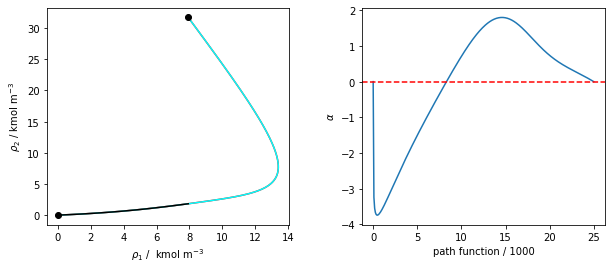

In [7]:
rhor1 = solr1.rho  / 1000  # kmol/m3
rhor2 = solr2.rho / 1000  # kmol/m3

rholiang =  soll.rho / 1000 # kmol/m3
alphas = soll.alphas
path = soll.path


fig = plt.figure(figsize = (10, 4))
fig.subplots_adjust( wspace=0.3)
ax1 = fig.add_subplot(121)
ax1.plot(rholiang[0], rholiang[1], color = 'red')
ax1.plot(rhor2[0], rhor2[1], color = 'cyan')
ax1.plot(rhor1[0], rhor1[1], color = 'black')
ax1.plot(rhov[0]/1000, rhov[1]/1000, 'o', color = 'k')
ax1.plot(rhol[0]/1000, rhol[1]/1000, 'o', color = 'k')
ax1.set_xlabel(r'$\rho_1$ /  kmol m$^{-3}$')
ax1.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$')

ax2 = fig.add_subplot(122)
ax2.plot(path/1000, alphas)
ax2.axhline(y = 0, linestyle = '--',color = 'r')
ax2.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'path function / 1000')

A more challenging mixture to analyze is ethanol and hexane. This mixture has several stationary points across the interface making its calculations tricky. Similar to before, equilibrium has to be computed. 

In [8]:
ethanol = component('ethanol2C', ms = 1.7728, sigma = 3.5592 , eps = 224.50,
                    lambda_r = 11.319, lambda_a = 6., eAB = 3018.05, rcAB = 0.3547,
                    rdAB = 0.4, sites = [1,0,1], cii= 5.3141080872882285e-20)

hexane = component('hexane', ms = 1.96720036, sigma = 4.54762477, eps = 377.60127994, 
                   lambda_r = 18.41193194, cii = 3.581510586936205e-19)


mix = mixture(hexane, ethanol)
# or
mix = hexane + ethanol

kij = 0.011818492037463553
Kij = np.array([[0, kij], [kij, 0]])
mix.kij_saft(Kij)
eos = saftvrmie(mix)

In [9]:
# computing phase equilibria
T = 298.15 # K
x = np.array([0.3, 0.7])
y0 = 1.*x
P0 = 8000. # Pa
sol = bubblePy(y0, P0, x, T, eos, full_output=True)
y, P = sol.Y, sol.P
vl, vv = sol.v1, sol.v2

#computing the density vector
rhox = x/vl
rhoy = y/vv

Then SGT is used with the different methods available for beta = 0

In [10]:
solr1 = sgt_mix_beta0(rhoy, rhox, T, P, eos, s=0, method='reference', full_output=True)
solr2 = sgt_mix_beta0(rhoy, rhox, T, P, eos, s=1, method='reference', full_output=True)
soll = sgt_mix_beta0(rhoy, rhox, T, P, eos, n=300, method='liang', full_output=True)

C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.12-py3.8-win-amd64.egg\SGTPy\vrmie_mixtures\ahs_monomer.py:121: RuntimeWarning: invalid value encountered in log
  log3 = np.log(xhi3_1)
C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.12-py3.8-win-amd64.egg\SGTPy\vrmie_mixtures\ghs_chain.py:135: RuntimeWarning: invalid value encountered in log
  k0 = -np.log(xhix_1) + (42*xhix - 39*xhix2 + 9*xhix3 - 2*xhix4)/(6*xhix_13)
C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.12-py3.8-win-amd64.egg\SGTPy\vrmie_mixtures\ares.py:851: RuntimeWarning: invalid value encountered in log
  aux1 = np.log(Xass) - Xass/2 + 1/2


In [11]:
print('Reference component method (1) : ', solr1.tension, 'mN/m')
print('Reference component method (2) : ', solr2.tension, 'mN/m')
print('Liang path Function: ', soll.tension, 'mN/m')

Reference component method (1) :  9.550416546627517 mN/m
Reference component method (2) :  14.807218180830272 mN/m
Liang path Function:  16.8261076240089 mN/m


Finally, the density profiles can be plotted. As can be seen, only Liang path function is able to compute the density profiles from one bulk phase to another correctly. 

Text(0.5, 0, 'path function / 1000')

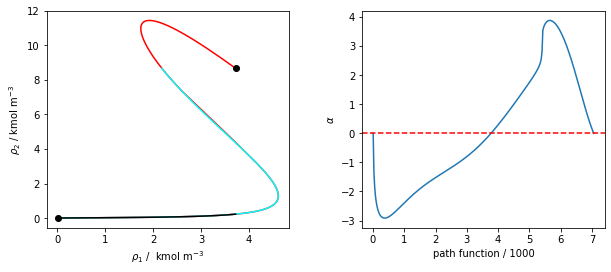

In [12]:
rhor1 = solr1.rho  / 1000  # kmol/m3
rhor2 = solr2.rho / 1000 # kmol/m3

rholiang =  soll.rho / 1000  # kmol/m3
alphas = soll.alphas
path = soll.path



fig = plt.figure(figsize = (10, 4))
fig.subplots_adjust( wspace=0.3)
ax1 = fig.add_subplot(121)
ax1.plot(rholiang[0], rholiang[1], color = 'red')
ax1.plot(rhor2[0], rhor2[1], color = 'cyan')
ax1.plot(rhor1[0], rhor1[1], color = 'black')
ax1.plot(rhoy[0]/1000, rhoy[1]/1000, 'o', color = 'k')
ax1.plot(rhox[0]/1000, rhox[1]/1000, 'o', color = 'k')
ax1.set_xlabel(r'$\rho_1$ /  kmol m$^{-3}$')
ax1.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$')

ax2 = fig.add_subplot(122)
ax2.plot(path/1000, alphas)
ax2.axhline(y = 0, linestyle = '--',color = 'r')
ax2.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'path function / 1000')

---
For further information about the ``sgt_mix_beta0`` function check out the documentation running: ``sgt_mix_beta0?``